About to get data
Trainset: 60000 , Testset : 10000
torch.Size([32, 1, 28, 28])


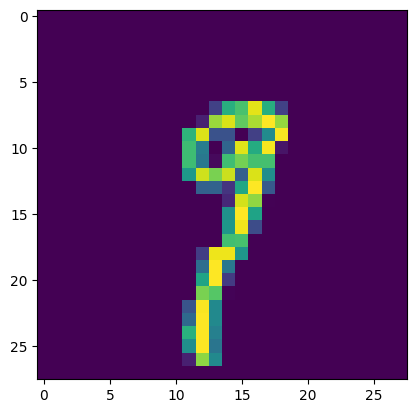

In [1]:
from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_DIR = Path("/content/mnist_data")
    EXP_DIR = Path("/content/drive/MyDrive/research/experiments")
except:
    DATA_DIR = Path("/home/avishkar/Desktop/research/mnist_data")
    EXP_DIR = Path("/home/avishkar/Desktop/research/experiments")
    print("About to get data")    

from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(7),
    transforms.Normalize([0.5], [0.5]),
])

trainset = MNIST(root=DATA_DIR, train=True, download=True, transform= transform)
testset = MNIST(root=DATA_DIR, train=False, download=True, transform = transform)
print(f"Trainset: {len(trainset)} , Testset : {len(testset)}")
classes = trainset.classes

train_loader = DataLoader(trainset, batch_size=32, num_workers=2, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, num_workers = 2, shuffle=False)

"""VISUALIZE DATA"""
import matplotlib.pyplot as plt

for i, (imgs, labels) in enumerate(train_loader):
    print(imgs.shape)
    img = imgs[0]
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.show()
    break

In [2]:
import torch
import torch.nn as nn

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config["img_size"]
        self.embed_dim = config["embed_dim"]
        self.patch_size = config["patch_size"]
        self.num_patches = (self.img_size // self.patch_size) **2
        self.num_channels = config["num_channels"]
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=self.num_channels,
                out_channels=self.embed_dim,
                kernel_size=self.patch_size,
                stride=self.patch_size,
            ),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(
            torch.randn(size=(1, 1,self.embed_dim)),
            requires_grad=True
            )
        self.position_embeddings = nn.Parameter(
            torch.randn(size=(1, self.num_patches+1, self.embed_dim)),
            requires_grad=True
            )
        self.dropout = nn.Dropout(config["dropout"])
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token,x ], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        
        return x

class ViT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.num_heads = config["num_heads"]
        self.num_classes = config["num_classes"]
        
        self.embeddings = PatchEmbeddings(config)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=self.num_heads,
            dropout=config["dropout"],
            activation = "gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder_blocks = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers = config["num_layers"]
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Linear(self.embed_dim, self.num_classes)
        )
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) # apply MLP on the CLS token only
        return x

In [3]:
"""UTILS"""
import json
from pathlib import Path

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, train_accuracies,test_accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "train_accuracies":train_accuracies,
        "test_accuracies":test_accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    train_accuracies=data["train_accuracies"]
    test_accuracies=data["test_accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, train_accuracies,test_accuracies, epoch
    
    

In [4]:
config ={
        "img_size":28,
        "embed_dim":16, # (PATCH_SIZE ** 2) * IN_CHANNELS
        "patch_size":4,
        "dropout":0.01,
        "num_channels":1,
        "num_heads":4,
        "num_layers":8,
        "num_classes":10,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "exp_name":"vit_mnist_40_epoch",
        "num_epoch":40
    }

import time
from tqdm import tqdm

class Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, test_loader, num_epochs):
        train_losses, test_losses, train_accuracies, test_accuracies = [], [] , [], []
        start = time.time()
        for epoch in range(num_epochs):
            ep_start = time.time()
            train_loss, train_accuracy = self.train_epoch(train_loader)
            test_loss, test_accuracy = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            ep_end = time.time()
            print(f"Epoch: {epoch}/{num_epochs}, Time : {(ep_end-ep_start):.2f}s")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
            print(f"Train Accuracy : {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
            
        save_experiment(self.model, num_epochs, config, train_losses, test_losses, train_accuracies,test_accuracies, EXP_DIR)
        end = time.time()
        print(f"Total Training Time : {(end-start):.2f}s")
            
    def train_epoch(self, train_loader):
        self.model.train()
        correct = 0
        running_train_loss = 0
        for i, (imgs, labels) in enumerate(tqdm(train_loader, position=0, leave=True)):
            imgs = imgs.float().to(self.device)
            labels = labels.type(torch.uint8).to(self.device)

            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            running_train_loss += loss.item() * len(imgs)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            predictions = torch.argmax(predictions, dim=1)
            correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(train_loader.dataset)
        train_loss = running_train_loss / len(train_loader.dataset)
        return train_loss, accuracy

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        running_test_loss = 0
        for i, (imgs, labels) in enumerate(tqdm(test_loader, position=0, leave=True)):
            imgs = imgs.float().to(self.device)
            labels = labels.type(torch.uint8).to(self.device)

            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            running_test_loss += loss.item() * len(imgs)

            predictions = torch.argmax(predictions, dim=1)
            correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        test_loss = running_test_loss / len(test_loader.dataset)
        return test_loss, accuracy
            
def main():
    model = ViT(config)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    trainer = Trainer(model, criterion, optimizer, config["device"])
    trainer.train(train_loader, test_loader, config["num_epoch"])

    

In [5]:
main()

/home/avishkar/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  1%|█▏                                                                                      | 24/1875 [00:04<05:53,  5.24it/s]


KeyboardInterrupt: 

In [ ]:
"""Visualize Losses"""

import matplotlib.pyplot as plt

model = ViT(config)
_, train_losses, test_losses, train_accuracies, test_accuracies,_ = load_experiment(model, config["exp_name"], EXP_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accuracies, label="Training Accuracy")
ax2.plot(test_accuracies, label="Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax1.legend()
plt.savefig("metrics.png")
plt.show()